## Day35 - NLP

In [1]:
from datetime import datetime, timedelta
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178

# read bearer token for authentication
f = open("../dataset/barrer-token.txt", "r")
BEARER_TOKEN = f.read()

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    #'query': '(tesla OR tsla OR elon musk) (lang:en)',
    'query': '(BTC OR btc OR bitcoin OR Bitcoin) (lang:en)',
    'max_results': '100',
    'tweet.fields': 'created_at,lang'
}

dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

def get_data(tweet):
    data = {
        'created_at': tweet['created_at'],
        'text': tweet['text']
    }
    return data

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)
    
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=7)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API

df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 7 days ago, break the loop
        break
        
    pre60 = time_travel(now, 230) 
    now = time_travel(now, 180)
    
    params['start_time'] = pre60
    params['end_time'] = now
    
    response = requests.get(endpoint,
                            params=params,
                            headers=headers) 
    now = pre60  
    
    for tweet in response.json()['data']:
        row = get_data(tweet)  
        df = df.append(row, ignore_index=True)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [189]:
print(f"Len = {len(df)}")
df.head()

Len = 4372


,created_at,text
0,2021-03-31T18:51:13.000Z,@CapricornFM @Itubanda @DeeNkomo_ I never thou...
1,2021-03-31T18:51:13.000Z,RT @BTCOVERFIAT: My girlfriend asked me the ot...
2,2021-03-31T18:51:13.000Z,Tesla can be bought with #Bitcoin\nHoping we'd...
3,2021-03-31T18:51:13.000Z,Crypto trading involves risk. Start without sp...
4,2021-03-31T18:51:13.000Z,RT @latokens: Airdrops allow us to spread the ...


In [190]:
def clean_text(text):
    """
    :param text: initial dirty tweet
    :return: cleaned tweet
    
    remove hashtag, remove tags, remove links,
    remove "RT" (retweet), substitute the "_" with a blank space
    """
    t = re.sub(r"#", "", text)
    t = re.sub(r"@[A-z]{1,}", "", t)
    t = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", t)
    t = re.sub(r"RT", "", t)
    t = re.sub(r"_", " ", t)
    
    return t

def get_sentiment(x):
    
    compound = analyzer.polarity_scores(x)['compound']
    
    if compound >= 0.4:
        return 1
    else: 
        return 0

df_cleaned = df.copy()
df_cleaned['text'] = df_cleaned.text.apply(lambda x : clean_text(x))

analyzer = SentimentIntensityAnalyzer()

df_cleaned['sentiment'] = df_cleaned.text.apply(lambda x : get_sentiment(x))
df_cleaned['created_at'] = pd.to_datetime(df_cleaned['created_at'])

In [191]:
df_cleaned.head()

,created_at,text,sentiment
0,2021-03-31 18:51:13+00:00,I never thought of meeting a legit bitcoin ...,1
1,2021-03-31 18:51:13+00:00,: My girlfriend asked me the other day: “Why ...,0
2,2021-03-31 18:51:13+00:00,Tesla can be bought with Bitcoin\nHoping we'd ...,1
3,2021-03-31 18:51:13+00:00,Crypto trading involves risk. Start without sp...,0
4,2021-03-31 18:51:13+00:00,: Airdrops allow us to spread the technology ...,1


In [192]:
import yfinance as yf
from datetime import datetime

tsla = yf.Ticker("btc-usd")

tsla_stock = tsla.history(
    start =df_cleaned['created_at'].min().strftime('%Y-%m-%d'),
    end=df_cleaned['created_at'].max().strftime('%Y-%m-%d'),
    interval='60m'
).reset_index()

In [193]:
df_grouped = df_cleaned.copy()
df_grouped['created_at'] = pd.to_datetime(df_grouped['created_at']).dt.strftime('%Y-%m-%d')

overall_sentiment = (df_grouped.groupby(by="created_at").sum() / df_grouped.groupby(by="created_at").count())['sentiment']

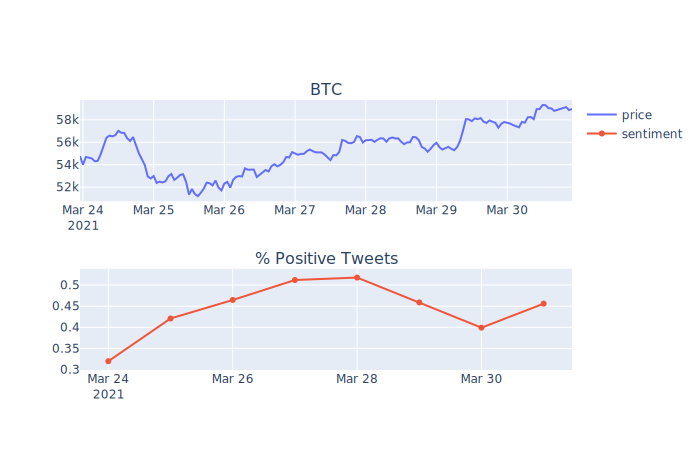

In [195]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, subplot_titles=("BTC", "% Positive Tweets"))

# Add traces
fig.add_trace(go.Scatter(x=tsla_stock['Datetime'], y=tsla_stock['Close'], name='price'), row=1, col=1)
fig.add_trace(go.Scatter(x=overall_sentiment.index, y=overall_sentiment, name='sentiment'), row=2, col=1)

# static rendering for github
fig.show("svg")